# Reconnaissance d'émotions dans les voix humaines


I. Mise en forme des données
Commençons par importer les librairies nécessaires pour analyser notre base de données.

In [ ]:
!pip install librosa numpy
import librosa
import numpy as np
import pandas as pd
import kagglehub
import os
import tensorflow
import matplotlib.pyplot as plt
import random
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
from sklearn.model_selection import train_test_split
from IPython.display import Audio
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Maintenant, il faut charger les données audios, et les convertir en array pour les manipuler.

On utilise la fonction `load()` de librosa. Il suffit de lui donner le chemin d'accès à la base de données, et la fonction sort un tableau numpy représentant le signal audio stocké sous la variable `y`, et le taux d'échantillonnage `sr`

Comme la base de données est un dossier de dossiers de fichiers audio, on crée deux listes vides qu'on va venir remplir petit à petit avec les signaux audio et les taux d'échantillonnage. Plus tard nous aurons besoin d'avoir les signaux audio sous la forme d'array, nous verrons alors comment convertir cette liste d'arrays en un seul array.



In [ ]:
# Charger le fichier audio
audio_dir_path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

# Import d'un seul fichier audio pour voir sa forme
"""
fichier_temoin = librosa.load(audio_dir_path + '/Actor_01/03-01-01-01-01-01-01.wav')
print(fichier_temoin[0].shape)
"""

# Stockage des fichiers audio et des taux d'échantillonnage dans un array
signaux_audio = []
taux_echantillonnage = []
emotions = []
all_audio_files = []

for dirname in os.listdir(audio_dir_path):
  for filename in os.listdir(audio_dir_path + '/' + dirname):
    chemin_fichier = os.path.join(audio_dir_path, dirname, filename)
    # Pour ne pas essayer de load les dossiers, on vérifie que l'objet à load est bien un fichier audio
    if os.path.isfile(chemin_fichier):
      y, sr = librosa.load(chemin_fichier)
      signaux_audio.append(y)
      taux_echantillonnage.append(sr)
      # On remplit la liste labels avec l'émotion de chaque fichier (représentée par le 3e nombre dans le nom du fichier)
      emotions.append(int(filename[7:8])-1)
      all_audio_files.append(chemin_fichier)


100%|██████████| 429M/429M [00:05<00:00, 76.8MB/s]

Extracting files...


Pour convertir notre liste d'arrays en un seul array, on pourrait utiliser la ligne `signaux_audio_array = np.array(signaux_audio)`.
Seulement, il faut impérativement que les fichiers audio aient la même taille. Or on peut constater que ce n'est pas le cas :



In [ ]:
print("Nombre de fichiers audio :", len(signaux_audio))
print(len(signaux_audio[0]))
print(len(signaux_audio[5]))
print(type(signaux_audio[0]))

Nombre de fichiers audio : 1440
79460
77988
<class 'numpy.ndarray'>


Il faut donc procéder autrement. Nous allons utiliser une technique familière : le padding. On ajoute des zéros aux signaux dont la longueur est inférieure au max des longueurs des signaux. On se retrouve donc avec des signaux de taille égale.

In [ ]:
# On trouve la longueur maximale des signaux
max_len = max(len(signal) for signal in signaux_audio)
print("Longueur maximale des signaux :", max_len)

# On remplit ensuite les signaux plus courts avec des zéros
signaux_audio_padded = []
for signal in signaux_audio:
    padding = np.zeros(max_len - len(signal))
    padded_signal = np.concatenate([signal, padding])
    signaux_audio_padded.append(padded_signal)

# La liste signaux_audio_padded contient désormais des signaux de longueurs égales :
print("Nombre de fichiers audio :", len(signaux_audio))
print(len(signaux_audio_padded[0]))
print(len(signaux_audio_padded[5]))

# Ainsi, on peut convertir facilement la liste en array
y = np.array(signaux_audio_padded)

Longueur maximale des signaux : 116247
Nombre de fichiers audio : 1440
116247
116247


La liste `taux_echantillonnage` ne pose pas le même problème : c'est une liste d'entiers qui représentent le taux d'échantillonnage de chaque piste audio. Comme la base de données est bien conçue, les taux d'échantillonnage sont tous égaux. On le vérifie rapidement ci-dessous.

On peut donc stocker dans `sr` le taux d'échantillonnage commun à tous les fichiers audio

In [ ]:
for i in range(len(taux_echantillonnage)-1) :
  if taux_echantillonnage[i] != taux_echantillonnage[i+1] :
    print("Erreur")

sr = taux_echantillonnage[0]

On a donc un array `y` regroupant tous les signaux audio de notre base de données, et un entier `sr` représentant la fréquence d'échantillonnage de chaque fichier.

In [ ]:
# Au besoin, on peut regarder à quoi ressemble l'array y
print("Shape de y :", y.shape)
print("Taille de y:", y.size)
print("Type de données dans y:", y.dtype)

Shape de y : (1440, 116247)
Taille de y: 167395680
Type de données dans y: float64


La partie extraction de données est donc terminée, on peut alors commencer à les exploiter.

#II. Exploitation des données

Les MFCC (*coefficients cepstraux en fréquence de Mel*) sont des caractéristiques audio qui imitent la perception humaine des sons. Ils sont utilisés pour extraire des informations essentielles du signal vocal pour diverses applications, comme la reconnaissance vocale et l'analyse des émotions.

Ils sont obtenus par un processus spécifique :


1. Le signal audio est divisé en fenêtres,
2. Dans chaque fenêtre, le signal est transformé en spectre de fréquence (transformée de Fourier)
3. Il est mappé sur l'échelle de fréquence de Mel, puis filtré et logarithmé
5. On applique enfin une transformée de cosinus discrète (DCT) pour obtenir les coefficients cepstraux


Analyser les MFCC plutôt que les fichiers audio bruts est avantageux dans notre cas car cela réduit drastiquement le nombre de paramètres. En effet, seules les caractéristiques vocales pertinentes sont conservées. De plus, le processus permet d'améliorer la robustesse aux variations non pertinentes (comme le bruit).

Les MFCC capturent les aspects essentiels de la parole, facilitant ainsi l'entraînement et l'efficacité des modèles de machine learning.


Pour extraire les MFCC on utilise la fonction feature.mfcc() de la librairie librosa. Les paramètres à préciser sont :

    y : Le signal audio en forme de tableau numpy
    sr : Le taux d'échantillonnage du signal audio en Hz
    n_mffc : Le nombre de coefficients MFCC à calculer. Ici on choisit 13 coefficients.

In [ ]:
# Extraire les caractéristiques MFCC
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
print(type(mfccs))

# Afficher les caractéristiques MFCC
print('Shape : ', mfccs.shape)
print('Type : ', mfccs.dtype)


<class 'numpy.ndarray'>
Shape :  (1440, 13, 228)
Type :  float64


In [ ]:
print(type(mfccs))

<class 'numpy.ndarray'>


La sortie de la fonction `librosa.feature.mfcc` est une matrice NumPy où chaque ligne représente une trame temporelle du signal audio et chaque colonne représente un coefficient MFCC. Le nombre de coefficients MFCC est spécifié par le paramètre n_mfcc (ici 13).

In [ ]:
class_labels = ['Neutral','Calm','Happy','Sad','Angry', 'Fearful', 'Disgust','Surprised']

train_data, test_data = train_test_split(mfccs, test_size=0.2, random_state=42)
train_labels, test_labels = train_test_split(emotions, test_size=0.2, random_state=42)

print("Shape de train_data :", train_data.shape)
print("Shape de test_data :", test_data.shape)

train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1)

print("Shape de train_data :", train_data.shape)
print("Shape de test_data :", test_data.shape)

# Conversion des listes d'étiquettes en Series pandas
train_labels_series = pd.Series(train_labels)
test_labels_series = pd.Series(test_labels)

# Création d'un encodage one-hot
train_labels_encoded = pd.get_dummies(train_labels_series).values
test_labels_encoded = pd.get_dummies(test_labels_series).values




Shape de train_data : (1152, 13, 228)
Shape de test_data : (288, 13, 228)
Shape de train_data : (1152, 13, 228, 1)
Shape de test_data : (288, 13, 228, 1)


# Création du modèle


In [ ]:
model = Sequential()

model.add(Conv2D(filters=7, kernel_size=(4,4), activation='relu', input_shape=(train_data.shape[1], train_data.shape[2], 1)))
model.add(Conv2D(filters=7, kernel_size=(2,2), activation='relu', input_shape=(train_data.shape[1], train_data.shape[2], 1)))
model.add(Conv2D(filters=7, kernel_size=(2,2), activation='relu', input_shape=(train_data.shape[1], train_data.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(filters=7, kernel_size=(2,2), activation='relu')) # Remove input_shape here
model.add(Conv2D(filters=7, kernel_size=(2,2), activation='relu')) # Remove input_shape here
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))



# On met 8 neurones dans la couche Dense car on a 8 émotions possibles attendues
model.add(Flatten())
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 10, 225, 7)          │             119 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 9, 224, 7)           │             203 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 223, 7)           │             203 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 4, 111, 7)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 111, 7)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 110, 7)           │             203 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 2, 109, 7)           │             203 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 54, 7)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 54, 7)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 378)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           3,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,963 (15.48 KB)

 Trainable params: 3,963 (15.48 KB)

 Non-trainable params: 0 (0.00 B)

None


#Entraînement du modèle

In [ ]:
epochs = 100
batch_size = 32

history = model.fit(train_data, train_labels_encoded,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(test_data, test_labels_encoded))

model.save('audio_emotion_detection_model_10epochs.h5')

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.1189 - loss: 2.2550 - val_accuracy: 0.1771 - val_loss: 2.0319
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.1594 - loss: 2.0246 - val_accuracy: 0.2569 - val_loss: 1.9599
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.1842 - loss: 1.9608 - val_accuracy: 0.2847 - val_loss: 1.8952
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.2992 - loss: 1.8564 - val_accuracy: 0.2917 - val_loss: 1.8079
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.3157 - loss: 1.7557 - val_accuracy: 0.3611 - val_loss: 1.6796
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.3586 - loss: 1.6900 - val_accuracy: 0.3819 - val_loss: 1.6203
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.3543 - loss: 1.6601 - val_accuracy: 0.3576 - val_loss: 1.6435
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.3750 - loss: 1.5845 - val_accuracy: 0

#Evaluation du modèle

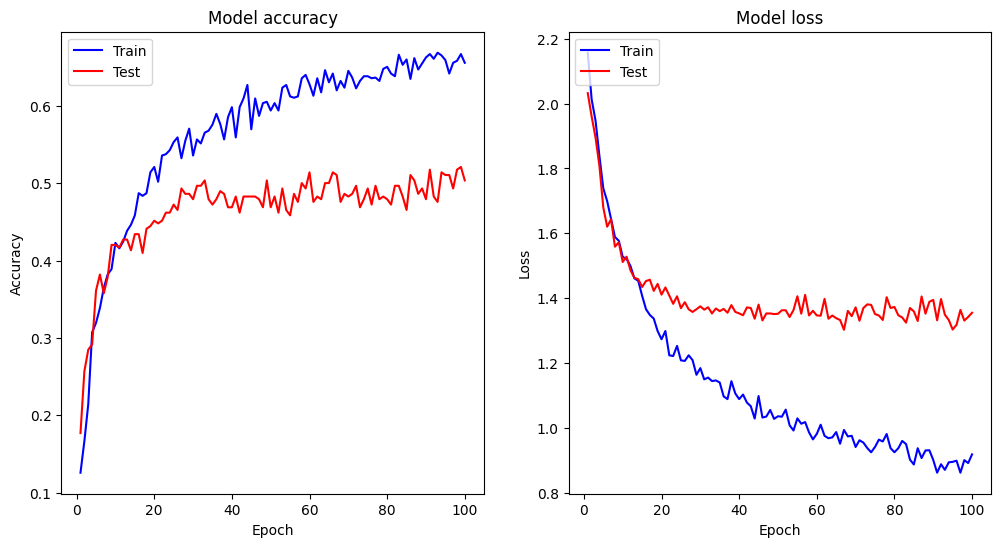

In [ ]:
epochs_list = range(1, len(history.history['accuracy']) + 1)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Création d'une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Tracer l'accuracy
ax1.plot(epochs_list, accuracy, 'b', label='Train accuracy')
ax1.plot(epochs_list, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

# Tracer la loss
ax2.plot(epochs_list, loss, 'b', label='Train loss')
ax2.plot(epochs_list, val_loss, 'r', label='Validation loss')
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Test du modèle
On veut pouvoir tester le modèle à la main. Pour ça, on voudrait pouvoir choisir un audio dans notre base de données, l'écouter pour savoir quelle émotion est utilisée, vérifier l'émotion renseignée dans la base de données, puis soumettre l'audio au modèle pour savoir s'il trouvera la bonne émotion.

In [ ]:
"""
random_audio_file = random.choice(all_audio_files)
print(random_audio_file)
"""


# Exemple de "fausse erreur" de prediction
random_audio_file = '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1/Actor_07/03-01-06-01-02-02-07.wav'



# On joue le fichier audio
Audio(random_audio_file)




In [ ]:
# On lit quelle émotion est associée à l'audio
emotion = class_labels[int(random_audio_file[102:103])-1]
print(emotion)

Fearful


In [ ]:

# Exemple d'un fichier audio en anglais enregistré nous même
random_audio_file = '/content/drive/MyDrive/record_out(3).wav'

# Exemple d'un fichier audio en français enregistré nous même
#random_audio_file = '/content/drive/MyDrive/record_out(5).wav'

audio_data, sample_rate = librosa.load(random_audio_file)
Audio(audio_data, rate=sample_rate)


In [ ]:
# On veut utiliser la fonction model.predict() avec random_audio_file
y_essai, sr_essai = librosa.load(random_audio_file)
mfccs_essai = librosa.feature.mfcc(y=y_essai, sr=sr_essai, n_mfcc=13)
print(mfccs_essai.shape)
mfccs_essai = np.array(mfccs_essai)
print(np.zeros(228-len(mfccs_essai[1])).shape)

# On utilise du padding pour que mfccs_essai[1]
pad_len = 228 - mfccs_essai.shape[1]
mfccs_essai = np.pad(mfccs_essai, ((0, 0), (0, pad_len)), 'constant')

#print(mfccs_essai.shape)


mfccs_essai = mfccs_essai.reshape(1, mfccs_essai.shape[0], mfccs_essai.shape[1], 1)
print(mfccs_essai.shape)
prediction = model.predict(mfccs_essai)
print(prediction)
predicted_emotion_index = np.argmax(prediction)
predicted_emotion = class_labels[predicted_emotion_index]
print(predicted_emotion)

(13, 166)
(62,)
(1, 13, 228, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[1.42159578e-16 1.08574105e-11 1.76056498e-03 7.68100023e-01
  6.04436640e-03 4.59718145e-02 1.69048533e-01 9.07466374e-03]]
Sad
